In [43]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [45]:
name_dataset = 'Byvsij_SSSR'

### load data

In [53]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(45046, 6)
CPU times: user 10.6 s, sys: 1.03 s, total: 11.6 s
Wall time: 9.72 s


In [54]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит..."
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'..."
2,2008-02-11 18:27:00,"""В России""",- Ключевым вопросом визита президента Украины...,Бывший СССР,ключевым вопросом визита президента украины ви...,"['ключевой', 'вопрос', 'визит', 'украина', 'ви..."
3,2008-02-11 23:05:00,"""В России""",- Парламентское большинство не намерено разбл...,Бывший СССР,парламентское большинство не намерено разблоки...,"['парламентский', 'большинство', 'намерить', '..."
4,2008-02-13 10:20:00,"""В России""",- Известный грузинский бизнесмен Бадри Патарк...,Бывший СССР,известный грузинский бизнесмен бадри_патаркаци...,"['известный', 'грузинский', 'бизнесмен', 'бадр..."


* parse data

In [55]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит...",2008,2
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'...",2008,2
2,2008-02-11 18:27:00,"""В России""",- Ключевым вопросом визита президента Украины...,Бывший СССР,ключевым вопросом визита президента украины ви...,"['ключевой', 'вопрос', 'визит', 'украина', 'ви...",2008,2
3,2008-02-11 23:05:00,"""В России""",- Парламентское большинство не намерено разбл...,Бывший СССР,парламентское большинство не намерено разблоки...,"['парламентский', 'большинство', 'намерить', '...",2008,2
4,2008-02-13 10:20:00,"""В России""",- Известный грузинский бизнесмен Бадри Патарк...,Бывший СССР,известный грузинский бизнесмен бадри_патаркаци...,"['известный', 'грузинский', 'бизнесмен', 'бадр...",2008,2


In [56]:
df.year.value_counts()

2014    7599
2015    7548
2008    4996
2009    4578
2016    4219
2010    3777
2017    3287
2018    3049
2011    2144
2013    1908
2012    1807
2019     134
Name: year, dtype: int64

In [57]:
df.month.value_counts()

4     4607
2     4177
5     4076
8     3980
7     3808
3     3802
6     3703
10    3579
9     3389
1     3376
12    3375
11    3174
Name: month, dtype: int64

In [58]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

* add docID

In [59]:
df['docID'] = list(range(df.shape[0]))

In [60]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[москва, киев, газовый, сфера, входить, зона, ..."
1,1,2008,2,"[премьерминистр, украина, юлия_тимошенко, заяв..."


In [61]:
print(df.shape)
df.isnull().sum()

(45046, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [62]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [63]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 408 ms, sys: 109 ms, total: 517 ms
Wall time: 442 ms


In [64]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [65]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Byvsij_SSSR", num_batches=46)
CPU times: user 14.6 s, sys: 249 ms, total: 14.8 s
Wall time: 2.71 s


In [66]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [67]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=5a1c5ad5-86e9-43c4-8287-e5736d69b48f, num_entries=18049)

In [68]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [81]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 10
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

#topic 10.........
	SparsityThetaScore: 0.5643187165260315
	SparsityPhiScore: 0.783882737159729
	PerplexityScore: 2351.791015625
	time: 0:00:20.646432
#topic 11.........
	SparsityThetaScore: 0.5848264098167419
	SparsityPhiScore: 0.7971582412719727
	PerplexityScore: 2298.64453125
	time: 0:00:45.283527
#topic 12.........
	SparsityThetaScore: 0.5974799990653992
	SparsityPhiScore: 0.8114854097366333
	PerplexityScore: 2246.038818359375
	time: 0:00:58.929243
#topic 13.........
	SparsityThetaScore: 0.6117029190063477
	SparsityPhiScore: 0.8236169219017029
	PerplexityScore: 2198.408447265625
	time: 0:00:59.058416
#topic 14.........
	SparsityThetaScore: 0.6264421939849854
	SparsityPhiScore: 0.8327528834342957
	PerplexityScore: 2165.554931640625
	time: 0:01:00.477918
#topic 15.........
	SparsityThetaScore: 0.6404001712799072
	SparsityPhiScore: 0.8420411348342896
	PerplexityScore: 2125.78955078125
	time: 0:00:59.193875
#topic 16.........
	SparsityThetaScore: 0.6518183946609497
	SparsityPhiScore: 0

In [ ]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

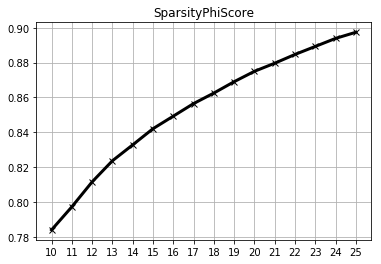

In [82]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [83]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.7, 0.8]

In [84]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.7: 2, 0.8: 14}

Text(0.5, 1.0, 'SparsityThetaScore')

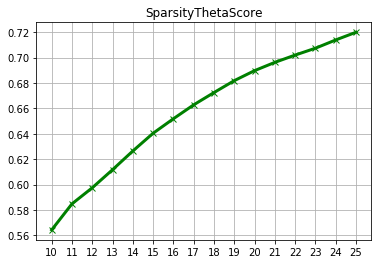

In [85]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [86]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.5, 0.6, 0.7]

In [87]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.5: 3, 0.6: 9, 0.7: 4}

Text(0.5, 1.0, 'PerplexityScore')

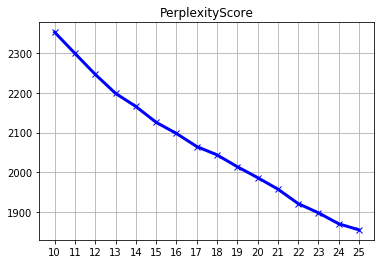

In [88]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [89]:
perplexity

[2351.791015625,
 2298.64453125,
 2246.038818359375,
 2198.408447265625,
 2165.554931640625,
 2125.78955078125,
 2097.781982421875,
 2065.01025390625,
 2044.0321044921875,
 2014.3359375,
 1986.9915771484375,
 1958.109375,
 1921.8037109375,
 1898.5699462890625,
 1871.1136474609375,
 1855.7406005859375]

### select the best model

In [90]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.7: 2, 0.8: 14}
d_stheta: {0.5: 3, 0.6: 9, 0.7: 4}


In [91]:
select_topics = 22 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

22


---

In [ ]:
'''
select_topics = 20

num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()
print(f'best_model.num_topics:{best_model.num_topics}')
'''

---

### print top words for each topics

In [92]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['миллион' 'миллиард' 'газа' 'предприятие' 'поставка' 'средство' 'цена'
 'сумма' 'электроэнергия' 'газ']
topic_1: ['здание' 'акция' 'участник' 'площадь' 'корреспондент' 'митинг' 'протест'
 'милиция' 'активист' 'улица']
topic_2: ['обстрел' 'огонь' 'позиция' 'прекращение' 'пункт' 'линия' 'мм'
 'направление' 'режим' 'миномёт']
topic_3: ['оборона' 'крым' 'военнослужащий' 'учение' 'корабль' 'войско' 'база'
 'нато' 'минобороны' 'граница']
topic_4: ['киргизия' 'азербайджан' 'бишкек' 'оон' 'узбекистан' 'временной' 'миссия'
 'снг' 'обсе' 'бакиев']
topic_5: ['армения' 'абхазия' 'ереван' 'армянский' 'абхазский' 'отставка'
 'премьерминистр' 'сухуми' 'член' 'пашинянин']
topic_6: ['белоруссия' 'граница' 'гуманитарный' 'белорусский' 'минск' 'помощь'
 'пограничный' 'груз' 'пункт' 'мчс']
topic_7: ['взрыв' 'погибнуть' 'пострадавший' 'погибший' 'больница' 'дом' 'ранение'
 'пожар' 'пострадать' 'состояние']
topic_8: ['выбор' 'избирательный' 'кандидат' 'фракция' 'выборы' 'голосование'
 'парламентск

### get topics-docs matrix

shape theta: (22, 45046)


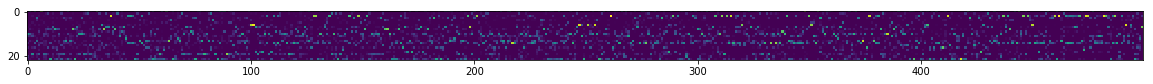

In [93]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [94]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21
24000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.081162,0.0,0.180839,...,0.0,0.000000,0.499068,0.0,0.0,0.0,0.238931,0.0,0.000000,0.000000
24001,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.328510,0.0,0.000000,...,0.0,0.000000,0.345951,0.0,0.0,0.0,0.292076,0.0,0.000000,0.033463
24002,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.353918,0.0,0.000000,...,0.0,0.000000,0.312114,0.0,0.0,0.0,0.222892,0.0,0.000000,0.000000
24003,0.0,0.000000,0.0,0.023544,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.114871,0.142121,0.0,0.0,0.0,0.575706,0.0,0.083342,0.021120
24004,0.0,0.012789,0.0,0.113806,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.124464,0.0,0.0,0.0,0.570874,0.0,0.000000,0.104515


## DataViz

In [95]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21
0,0,2008,2,0.433729,0.000000,0.0,0.0,0.021411,0.002973,0.047639,...,0.112211,0.193255,0.0,0.000000,0.022498,0.000000,0.017039,0.000000,0.026408,0.009009
1,1,2008,2,0.595476,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.096220,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.169497,0.000000
2,2,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.012282,...,0.159710,0.619182,0.0,0.000000,0.000000,0.000000,0.000000,0.098381,0.000000,0.110445
3,3,2008,2,0.000000,0.184165,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.144147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.096138,0.0,0.049107,0.059107,0.005616,0.000000,0.008203,0.147644,0.000000


In [96]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 22)


topic_0    topic_1   topic_2    topic_3   topic_4    topic_5  \
year month                                                                   
2008 2       5.492892   4.233420  0.239153   1.228619  1.698135   8.226724   
     3      24.647877  20.012241  5.943365   7.973896  9.417150  12.124409   
     4      16.787830  14.113843  2.590317  17.170328  6.336670  14.957608   
     5      12.698258  15.239322  2.293649  26.724195  8.796383  16.660278   
     6      12.813042  12.797353  2.967252  15.282129  4.390054  11.520972   

              topic_6    topic_7    topic_8    topic_9    ...       topic_12  \
year month                                                ...                  
2008 2       1.350490   7.043914  12.409540   3.784482    ...       1.266065   
     3       7.639961  22.448563  20.368845  15.406806    ...      14.929720   
     4       7.158126  18.997597  16.650482  24.158848    ...      11.733158   
     5      10.526740  33.159515  27.422283  17.694441    ...      10.183885   
     6       9.300848  39.106216  12.251497  19.977470    ...       9.398525   

             topic_13  topic_14   topic_15   topic_16   topic_17   topic_18  \
year month                                                                    
2008 2       8.906828  0.828020   9.567052   2.850121   2.248303   2.670728   
     3      40.863964  2.201318  20.133432  14.049856  10.525912   9.216154   
     4      44.423355  1.984044  26.212976  16.402122   9.122753   8.577242   
     5      46.049534  2.599358  44.280094  21.133474   9.787307  12.689351   
     6      40.417618  1.042552  30.809513  17.421066   6.189946   7.825546   

            topic_19   topic_20   topic_21  
year month                                  
2008 2      1.815776  10.011753   3.099423  
     3      6.552118  24.493677  21.409294  
     4      7.677931  17.468025  15.072263  
     5      7.137274  22.501520  15.365364  
     6      7.444602  14.398539  11.930733  

[5 rows x 22 columns]

### straightforward matrix heatmap

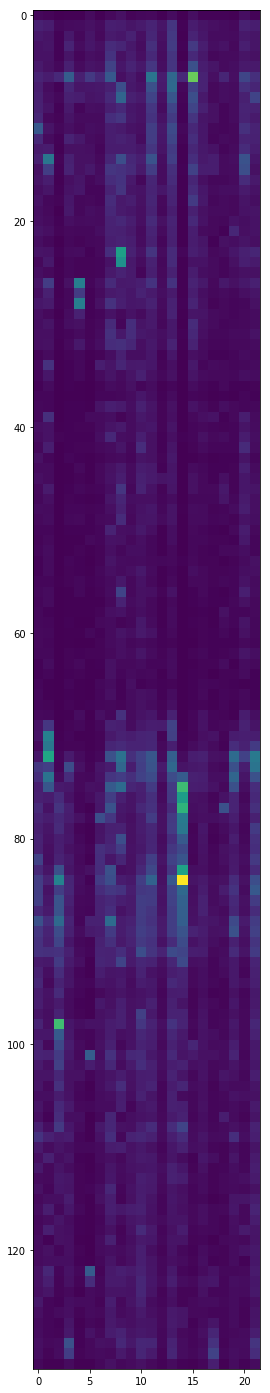

In [97]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [99]:
import pygal
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [100]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [101]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [102]:
import joypy # !pip install joypy

In [103]:
print(joined.shape)
joined.head()

(45046, 25)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21
0,0,2008,2,0.433729,0.000000,0.0,0.0,0.021411,0.002973,0.047639,...,0.112211,0.193255,0.0,0.000000,0.022498,0.000000,0.017039,0.000000,0.026408,0.009009
1,1,2008,2,0.595476,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.096220,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.169497,0.000000
2,2,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.012282,...,0.159710,0.619182,0.0,0.000000,0.000000,0.000000,0.000000,0.098381,0.000000,0.110445
3,3,2008,2,0.000000,0.184165,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.144147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.096138,0.0,0.049107,0.059107,0.005616,0.000000,0.008203,0.147644,0.000000


In [104]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,date
0,0,2008,2,0.433729,0.000000,0.0,0.0,0.021411,0.002973,0.047639,...,0.193255,0.0,0.000000,0.022498,0.000000,0.017039,0.000000,0.026408,0.009009,2008-02-01
1,1,2008,2,0.595476,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.169497,0.000000,2008-02-01
2,2,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.012282,...,0.619182,0.0,0.000000,0.000000,0.000000,0.000000,0.098381,0.000000,0.110445,2008-02-01
3,3,2008,2,0.000000,0.184165,0.0,0.0,0.000000,0.000000,0.000000,...,0.144147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.096138,0.0,0.049107,0.059107,0.005616,0.000000,0.008203,0.147644,0.000000,2008-02-01


In [105]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()

dd2=dd2.reset_index()

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.433729
1,2008-02-01,topic_0,0.595476
7,2008-02-01,topic_0,0.672846
8,2008-02-01,topic_0,0.002393
9,2008-02-01,topic_0,0.043576


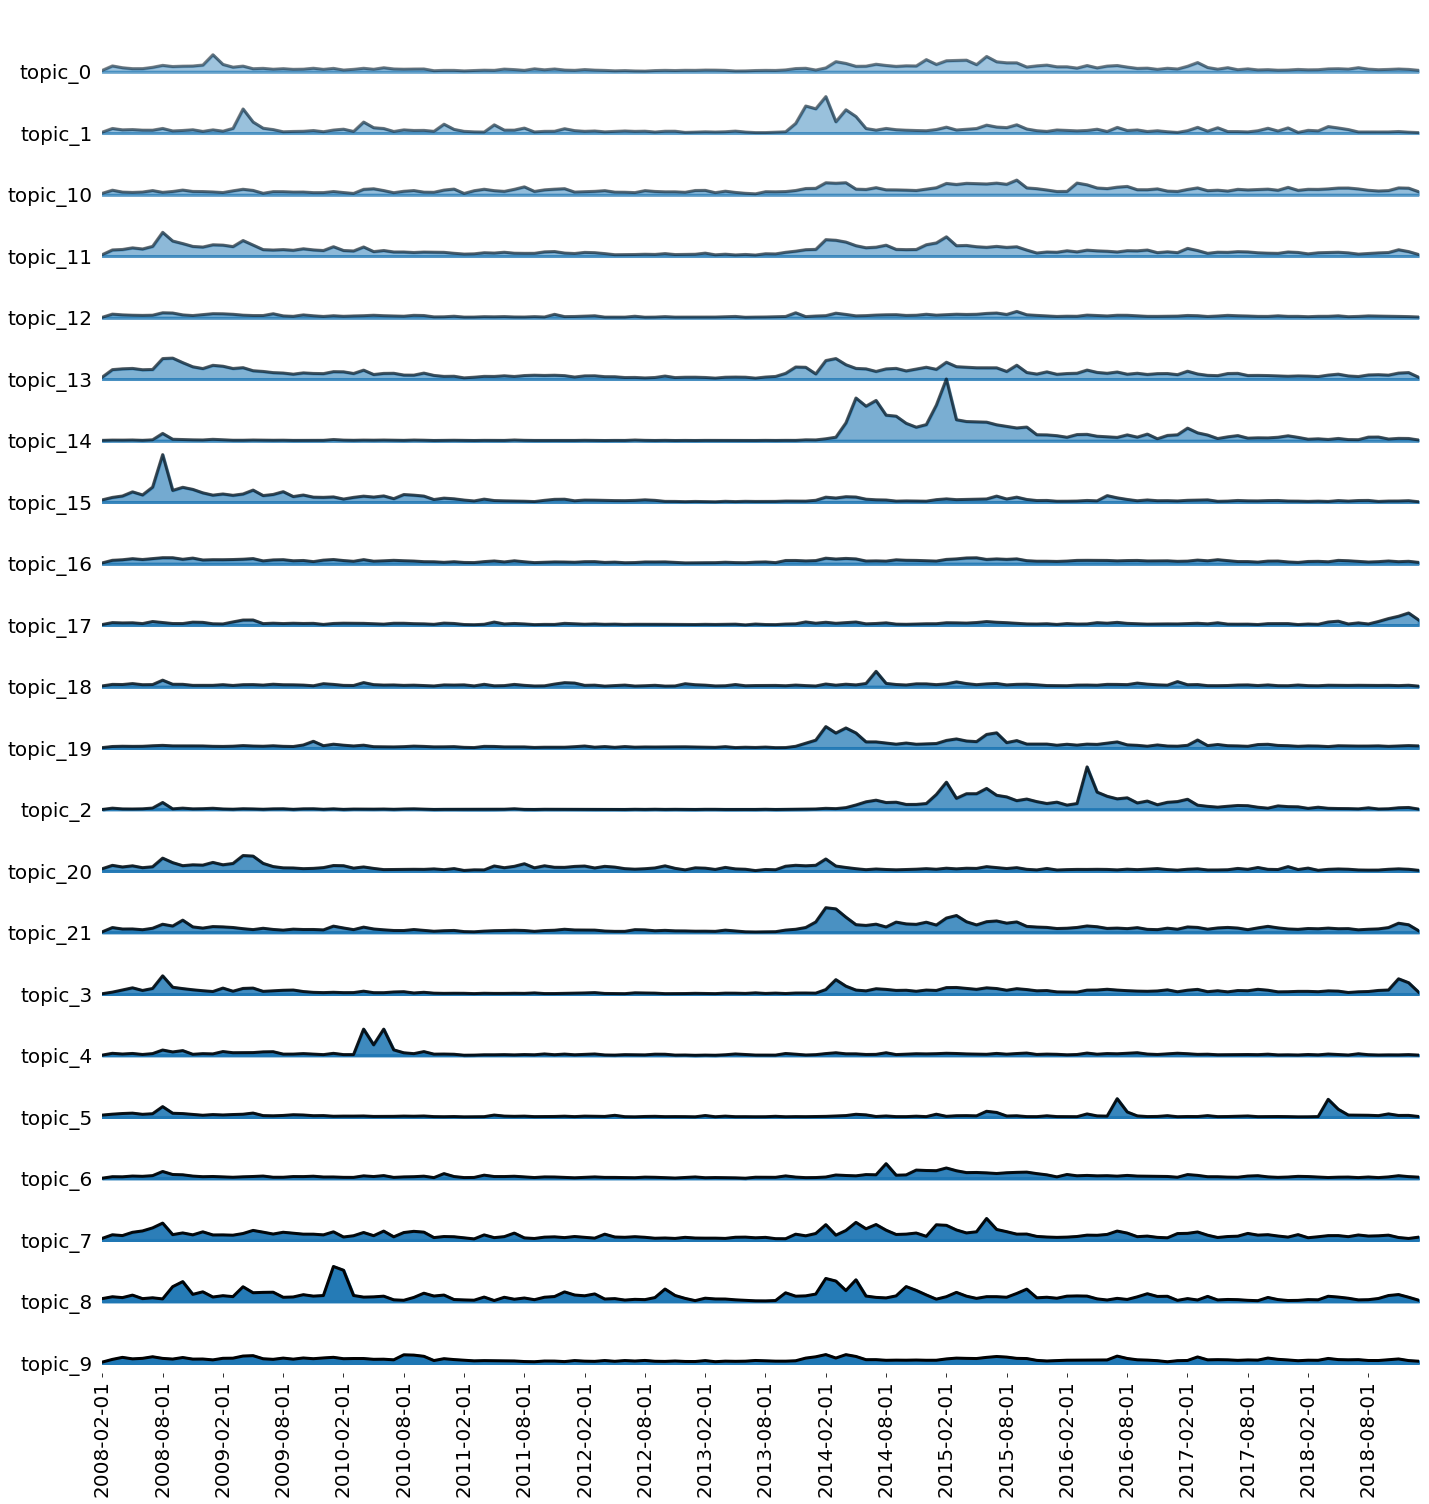

In [106]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [107]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")